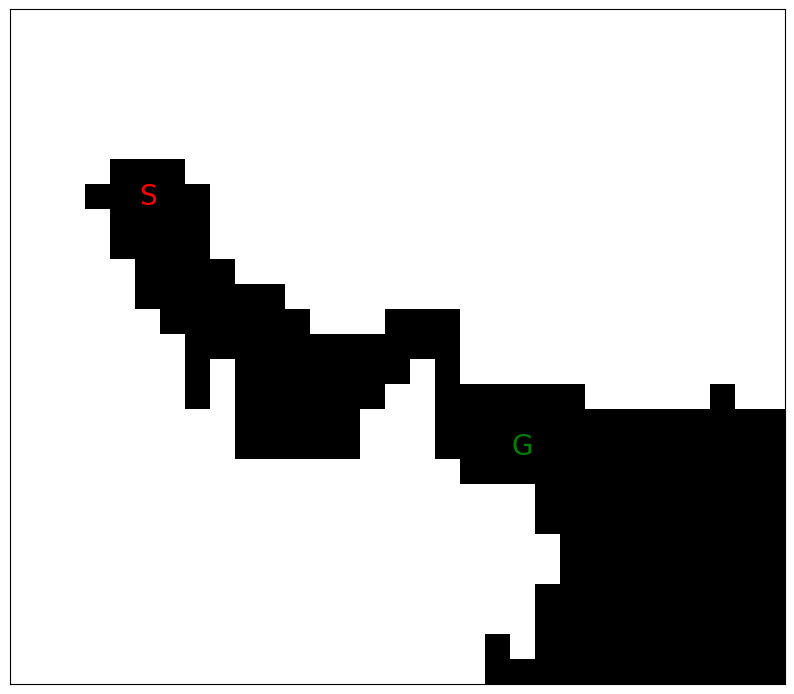

In [11]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Add, Subtract
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
from global_land_mask import globe
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime, timedelta
from global_land_mask import globe
import os
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.interpolate import splprep, splev
import multiprocessing as mp
from tensorflow.keras import backend as K
from IPython.display import clear_output
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
RECTANGLE_COORDS = [46.248, 19.859, 64.881, 32.955]
SOLAR_PANEL_AREA = 3000
SOLAR_PANEL_EFFICIENCY = 0.1726
RHO_AIR = 1.225
KITE_AREA = 500
LIFT_COEFFICIENT = 1.0
DRAG_COEFFICIENT = 0.1
SHIP_SPEED = 10.29  # m/s
GRID_SIZE_DEGREES = 0.01
MAX_STEPS_PER_EPISODE = 3945
TIME_INCREMENT_MINUTES = 2.22*60
goal_reward = 1000000
wall_penalty = -20000
energy_consumption_penalty = -100

# Directories for wind and solar data
WIND_DATA_DIR = "mera"
SOLAR_DATA_DIR = "solar energy"

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

    def add(self, error, transition):
        priority = (np.abs(error) + 1e-5) ** self.alpha
        self.buffer.append(transition)
        self.priorities.append(priority)

    def sample(self, batch_size, beta=0.4):
        scaled_priorities = np.array(self.priorities) ** self.alpha
        sample_probs = scaled_priorities / np.sum(scaled_priorities)
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)
        samples = np.array(self.buffer)[indices]
        weights = (len(self.buffer) * sample_probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, weights

    def update_priorities(self, indices, errors):
        for i, error in zip(indices, errors):
            self.priorities[i] = (np.abs(error) + 1e-5) ** self.alpha

    def __len__(self):
        return len(self.buffer)

class DoubleDuelingDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, batch_size=64, update_target_frequency=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_frequency = update_target_frequency
        self.learning_rate = learning_rate

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        self.memory = PrioritizedReplayBuffer(2000)
        self.steps = 0

    def _build_model(self):
        state_input = Input(shape=(self.state_size,))
        hidden1 = Dense(64, activation='relu')(state_input)
        hidden2 = Dense(64, activation='relu')(hidden1)

        value_fc = Dense(64, activation='relu')(hidden2)
        value = Dense(1, activation='linear')(value_fc)

        advantage_fc = Dense(64, activation='relu')(hidden2)
        advantage = Dense(self.action_size, activation='linear')(advantage_fc)

        advantage_mean = Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(advantage)
        advantage_centered = Subtract()([advantage, advantage_mean])
        q_values = Add()([value, advantage_centered])

        model = Model(inputs=state_input, outputs=q_values)
        model.compile(optimizer=Adam(learning_rate= 0.01), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.reshape(state, [1, self.state_size])
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        state = np.reshape(state, [1, self.state_size])
        next_state = np.reshape(next_state, [1, self.state_size])
        target = reward
        if not done:
            target += self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)[0])
        current_q = self.model.predict(state, verbose=0)[0][action]
        error = abs(current_q - target)
        self.memory.add(error, (state, action, reward, next_state, done))

    def train(self, beta=0.4):
        if len(self.memory) < self.batch_size:
            return

        minibatch, indices, weights = self.memory.sample(self.batch_size, beta)
        states = np.concatenate([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.concatenate([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])

        target_q_values = self.model.predict(states, verbose=0)
        next_model_q_values = self.model.predict(next_states, verbose=0)
        next_target_q_values = self.target_model.predict(next_states, verbose=0)
        max_next_actions = np.argmax(next_model_q_values, axis=1)
        targets = rewards + (1 - dones) * self.gamma * next_target_q_values[np.arange(self.batch_size), max_next_actions]

        errors = np.abs(target_q_values[np.arange(self.batch_size), actions] - targets)
        for i in range(self.batch_size):
            target_q_values[i, actions[i]] = targets[i]

        self.memory.update_priorities(indices, errors)
        self.model.fit(states, target_q_values, epochs=1, verbose=0, sample_weight=weights)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.steps += 1
        if self.steps % self.update_target_frequency == 0:
            self.update_target_model()

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

class Maze:
    def __init__(self, maze, start_position, goal_position, height, width, lat, lon):
        self.maze = maze
        self.maze_height = height
        self.maze_width = width
        self.start_position = start_position
        self.goal_position = goal_position
        self.lat = lat
        self.lon = lon

    def show_maze(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

# Helper functions for the environment and training
def load_and_preprocess_data(date, directory, variable):
    filename = f"MERRA2_400.tavg1_2d_flx_Nx.{date.strftime('%Y%m%d')}.nc4.nc4" if variable in ['ULML', 'VLML'] else f"MERRA2_400.tavg1_2d_rad_Nx.{date.strftime('%Y%m%d')}.nc4_2.nc4"
    filepath = os.path.join(directory, filename)
    dataset = Dataset(filepath)
    data = dataset.variables[variable][:]
    return data

def load_and_preprocess_data_once(dates, directory, variables):
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap(load_and_preprocess_data, [(date, directory, variable) for date in dates for variable in variables])
    pool.close()
    pool.join()

    # Organize results into a dictionary
    data = {var: [] for var in variables}
    for i, variable in enumerate(variables):
        data[variable] = results[i::len(variables)]
    
    return data

def load_data_parallel(dates, directory, variables):
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap(load_and_preprocess_data, [(date, directory, variable) for date in dates for variable in variables])
    pool.close()
    pool.join()
    return results

def calculate_apparent_wind(uwind, vwind, ship_speed, ship_direction):
    wind_speed = np.sqrt(uwind**2 + vwind**2)
    wind_direction = np.arctan2(vwind, uwind)
    apparent_wind_speed = np.sqrt((wind_speed * np.cos(wind_direction - ship_direction) - ship_speed)**2 + (wind_speed * np.sin(wind_direction - ship_direction))**2)
    apparent_wind_direction = np.arctan2(wind_speed * np.sin(wind_direction - ship_direction), wind_speed * np.cos(wind_direction - ship_direction) - ship_speed)
    return apparent_wind_speed, apparent_wind_direction

# Calculate kite power
def calculate_kite_power(apparent_wind_speed, kite_area, lift_coefficient, drag_coefficient):
    lift_force = 0.5 * RHO_AIR * apparent_wind_speed**2 * kite_area * lift_coefficient
    drag_force = 0.5 * RHO_AIR * apparent_wind_speed**2 * kite_area * drag_coefficient
    power_output = (lift_force - drag_force) * apparent_wind_speed
    return power_output

# Calculate solar power output
def calculate_solar_power_output(solar_panel_area, solar_panel_efficiency, swgnt):
    power_output = solar_panel_area * solar_panel_efficiency * swgnt
    return power_output

# Calculate the Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def get_state(maze, current_position, goal_position):
    distance_to_goal = haversine_distance(
        maze.lat[current_position[1]], maze.lon[current_position[0]],
        maze.lat[goal_position[1]], maze.lon[goal_position[0]]
    )
    state = np.array([current_position[0], current_position[1], distance_to_goal])
    return state

import time

def finish_episode(agent, maze, current_episode, start_time, wind_data, solar_data, train=True, optimization_goal='distance'):
    start_time_episode = time.time()
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    solar_fluxes = []
    kite_powers = []

    time_increment = timedelta(minutes=TIME_INCREMENT_MINUTES)
    current_time = start_time

    while not is_done and episode_step < MAX_STEPS_PER_EPISODE:
        state = np.reshape(get_state(maze, current_state, maze.goal_position), [1, agent.state_size])
        action = agent.act(state)
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        if (0 <= next_state[0] < maze.maze_width) and (0 <= next_state[1] < maze.maze_height):
            if maze.maze[next_state[1], next_state[0]] == 1:
                reward = wall_penalty
                next_state = current_state
            elif next_state == maze.goal_position:
                path.append(next_state)
                reward = goal_reward - episode_step  # Reward for reaching the goal earlier
                is_done = True
            else:
                path.append(next_state)
                lat1, lon1 = maze.lat[current_state[1]], maze.lon[current_state[0]]
                lat2, lon2 = maze.lat[next_state[1]], maze.lon[next_state[0]]
                lat_end, lon_end = maze.lat[maze.goal_position[1]], maze.lon[maze.goal_position[0]]
                distance_reward = -haversine_distance(lat1, lon1, lat2, lon2) - haversine_distance(lat2, lon2, lat_end, lon_end)

                # Calculate wind and solar effects
                lat_idx, lon_idx = int((lat1 - RECTANGLE_COORDS[1]) / 0.5), int((lon1 - RECTANGLE_COORDS[0]) / 0.625)
                uwind = wind_data['uwind'][:, lat_idx, lon_idx]
                vwind = wind_data['vwind'][:, lat_idx, lon_idx]
                swgnt = solar_data['swgnt'][:, lat_idx, lon_idx]

                apparent_wind_speed, apparent_wind_direction = calculate_apparent_wind(uwind, vwind, SHIP_SPEED, np.arctan2(lon2 - lon1, lat2 - lat1))
                kite_power = calculate_kite_power(apparent_wind_speed, KITE_AREA, LIFT_COEFFICIENT, DRAG_COEFFICIENT)
                solar_power_output = calculate_solar_power_output(SOLAR_PANEL_AREA, SOLAR_PANEL_EFFICIENCY, swgnt)

                # Calculate energy consumption
                energy_gain = kite_power.mean() + solar_power_output.mean()
                energy_reward = energy_consumption_penalty * energy_gain

                if optimization_goal == 'distance':
                    reward = distance_reward
                elif optimization_goal == 'energy':
                    reward = energy_reward
                else:
                    reward = distance_reward + energy_reward

                # Add a small step penalty to encourage faster goal reaching
                step_penalty = -1
                reward += step_penalty

                # Record values for plotting later
                solar_fluxes.append(solar_power_output.mean())
                kite_powers.append(kite_power.mean())

                # Update time
                current_time += time_increment

        else:
            reward = wall_penalty
            next_state = current_state

        episode_reward += reward
        episode_step += 1

        if train:
            next_state_reshaped = np.reshape(get_state(maze, next_state, maze.goal_position), [1, agent.state_size])
            agent.remember(state, action, reward, next_state_reshaped, is_done)
            if len(agent.memory) >= agent.batch_size:
                agent.train()

        current_state = next_state

    if not is_done:
        print(f"Episode {current_episode + 1} reached max steps without reaching the goal.")

    end_time_episode = time.time()
    print(f"Episode duration: {end_time_episode - start_time_episode} seconds")

    return episode_reward, episode_step, path, solar_fluxes, kite_powers

def train_agent(agent, maze, start_time, wind_data, solar_data, num_episodes=100, optimization_goal='distance'):
    episode_rewards = []
    episode_steps = []
    best_path = []
    best_solar_fluxes = []
    best_kite_powers = []
    best_reward = -float('inf')
    start_training_time = time.time()

    for episode in range(num_episodes):
        episode_start_time = time.time()

        episode_reward, episode_step, path, solar_fluxes, kite_powers = finish_episode(agent, maze, episode, start_time, wind_data, solar_data, train=True, optimization_goal=optimization_goal)
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)

        if episode_reward > best_reward:
            best_reward = episode_reward
            best_path = path
            best_solar_fluxes = solar_fluxes
            best_kite_powers = kite_powers

        # Print progress every episode
        print(f"Episode {episode + 1} - Steps: {episode_step}, Reward: {episode_reward}")

        # Estimate and print remaining time
        episode_end_time = time.time()
        episode_duration = episode_end_time - episode_start_time
        elapsed_time = episode_end_time - start_training_time
        remaining_time = (num_episodes - (episode + 1)) * (elapsed_time / (episode + 1))

        print(f"Estimated time to finish: {remaining_time / 60:.2f} minutes")
        print(f"Episode duration: {episode_duration} seconds")

        agent.adjust_epsilon(episode)

    print(f"Best Reward: {best_reward}")
    print(f"Best Path: {best_path}")
    print(f"Best Solar Fluxes: {best_solar_fluxes}")
    print(f"Best Kite Powers: {best_kite_powers}")

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward per Episode')
    average_reward = sum(episode_rewards) / len(episode_rewards)
    print(f"The average reward is: {average_reward}")

    plt.subplot(2, 2, 2)
    plt.plot(episode_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title('Steps per Episode')
    average_steps = sum(episode_steps) / len(episode_steps)
    print(f"The average steps is: {average_steps}")

    plt.subplot(2, 2, 3)
    plt.imshow(maze.maze, cmap='gray')
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
    for row, col in best_path:
        plt.text(row, col, "x", va='center', color='blue', fontsize=5)
    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.title('Final Path Learned')

    plt.subplot(2, 2, 4)
    plt.plot(best_solar_fluxes, label='Solar Flux (W/m^2)')
    plt.plot(best_kite_powers, label='Kite Power (W)')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Solar Flux and Kite Power per Step')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize environment and agent
origin = [49.469, 29.362]
destination = [58.836, 24.385]
if origin[0] > destination[0]:
    origin, destination = destination, origin

lat = np.arange(19.859, 32.955, 0.5)
lon = np.arange(46.248, 64.881+0.625,0.625 )
lon_grid, lat_grid = np.meshgrid(lon, lat)
z = globe.is_land(lat_grid, lon_grid)
z = np.array(z[::-1].astype(int))

test_lat = lat - origin[1]
test_lat = test_lat[::-1]
test_lon = lon - origin[0]
start_pos_lat = np.where(abs(test_lat) == min(abs(test_lat)))
start_pos_lon = np.where(abs(test_lon) == min(abs(test_lon)))
startpos = (start_pos_lon[0][0], start_pos_lat[0][0])

test_lat = lat - destination[1]
test_lat = test_lat[::-1]
test_lon = lon - destination[0]
destination_pos_lat = np.where(abs(test_lat) == min(abs(test_lat)))
destination_pos_lon = np.where(abs(test_lon) == min(abs(test_lon)))
destinationpos = (destination_pos_lon[0][0], destination_pos_lat[0][0])
lat = lat[::-1]
lon = lon[::-1]

maze = Maze(z, startpos, destinationpos, len(z), len(z[0]), lat, lon)
maze.show_maze()
actions = [(-1, 0), (1, 0), (0, -1), (0, 1), (1, 1), (1, -1), (-1, 1), (-1, -1)]


In [14]:

state_size = 3
action_size = len(actions)
num_episodes = 1000
start_time = datetime(2023, 1, 1)

agent = DoubleDuelingDQNAgent(state_size, action_size, num_episodes)

# Load wind and solar data
# Load wind and solar data once before training
dates = [start_time + timedelta(days=i) for i in range(num_episodes)]
wind_data = {
    'uwind': load_and_preprocess_data(start_time, WIND_DATA_DIR, 'ULML'),
    'vwind': load_and_preprocess_data(start_time, WIND_DATA_DIR, 'VLML')
}
solar_data = {
    'swgnt': load_and_preprocess_data(start_time, SOLAR_DATA_DIR, 'SWGNT')
}


In [15]:
# Training the agent
train_agent(agent, maze, start_time, wind_data, solar_data, num_episodes=num_episodes, optimization_goal='energy')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (64, 5) + inhomogeneous part.